# CellChat

In [10]:
options(warn=-1, stringsAsFactors=FALSE)

In [11]:
library_load <- suppressMessages(
    
    list(
        
        # CellTalk
        library(CellChat), 
        
        # Seurat 
        library(Seurat), 
        
        # Data 
        library(tidyverse), 
        
        # Plotting 
        library(ComplexHeatmap), 
        library(circlize), 
        library(viridis), 
        library(ggplotify), 
        library(ggrepel), 
        library(cowplot)
        
    )
)

In [12]:
random_seed <- 42
set.seed(random_seed)

In [13]:
ht_opt$message=FALSE # ComplexHeatmap 

In [14]:
# Set working directory to project root
setwd("/research/peer/fdeckert/FD20200109SPLENO")

In [15]:
# Source files
source("plotting_global.R")
source("bin/cell_type.R")
source("bin/cellchat.R")

In [16]:
# Plotting Theme
ggplot2::theme_set(theme_global_set()) # From project global source()

# Parameter and files 

In [17]:
so_file <- "data/object/pp.rds"

In [18]:
compute_cellchat <- FALSE

# Import 

In [19]:
so <- readRDS(so_file)

In [20]:
so$cell_type_main <- factor(so$cell_type_main, levels=unique(cell_type_main_order))
so$cell_type_fine <- factor(so$cell_type_fine, levels=cell_type_fine_order)

## Pre-process cellchat objects for each treatment condition 

In [21]:
cellchat_pp <- function(so, group_by) {
    
    cnt <- as.matrix(GetAssayData(so, assay="RNA", slot="data"))
    cnt <- cnt[rowSums(cnt)>0, ]
    
    cellchat <- createCellChat(object=cnt, meta=so@meta.data, group.by=group_by)
    cellchat <- setIdent(cellchat, ident.use=group_by)
    cellchat@DB <- CellChatDB.mouse # Add DB slot with interaction, complex, cofactor, and geneInfo data frames 
    cellchat <- subsetData(cellchat) # Subset data for signaling genes 
    cellchat <- identifyOverExpressedGenes(cellchat, thresh.p=1) # Identify DE signaling genes stored in object@var.features. Disabled for now since I want to keep all genes for analysis. 
    cellchat <- identifyOverExpressedInteractions(cellchat) # Filter interaction based on over expressed genes. Adds @LR$LRsig which is a pruned persion of cellchat@DB$interaction
    cellchat <- projectData(cellchat, PPI.mouse) # Project protein data 
    cellchat <- computeCommunProb(cellchat, raw.use=FALSE, type="truncatedMean", trim=0.01) # Using the information from DB compute interaction strength (probability) in object@net$prob and associated p-values in object@net$pval. 
    cellchat <- computeCommunProbPathway(cellchat) # Summarise L-R interaction on pathway level. Return object@netP$prob is the pathway probability and significant pathways are stored in object@netP$pathways
    cellchat <- aggregateNet(cellchat) # Updates object@net with counts and weights 
    
    return(cellchat)
    
}

In [22]:
if(compute_cellchat) {
    
    cellchat_main_nacl <- cellchat_pp(subset(so, subset=treatment=="NaCl"), group_by="cell_type_main")
    saveRDS(cellchat_main_nacl, "data/object/cellchat/cellchat_main_nacl.rds")

} else {
    
    cellchat_main_nacl <- readRDS("data/object/cellchat/cellchat_main_nacl.rds")
    
}

In [23]:
if(compute_cellchat) {
    
    cellchat_main_cpg <- cellchat_pp(subset(so, subset=treatment=="CpG"), group_by="cell_type_main")
    saveRDS(cellchat_main_cpg, "data/object/cellchat/cellchat_main_cpg.rds")

} else {
    
    cellchat_main_cpg <- readRDS("data/object/cellchat/cellchat_main_cpg.rds")
    
}

In [24]:
if(compute_cellchat) {
    
    cellchat_fine_nacl <- cellchat_pp(subset(so, subset=treatment=="NaCl"), group_by="cell_type_fine")
    saveRDS(cellchat_fine_nacl, "data/object/cellchat/cellchat_fine_nacl.rds")

} else {
    
    cellchat_fine_nacl <- readRDS("data/object/cellchat/cellchat_fine_nacl.rds")
    
}

In [25]:
if(compute_cellchat) {
    
    cellchat_fine_cpg <- cellchat_pp(subset(so, subset=treatment=="CpG"), group_by="cell_type_fine")
    saveRDS(cellchat_fine_cpg, "data/object/cellchat/cellchat_fine_cpg.rds")

} else {
    
    cellchat_fine_cpg <- readRDS("data/object/cellchat/cellchat_fine_cpg.rds")
    
}

# Merge CellChat data objects 

In [26]:
cellchat_main_list <- list(NaCl=cellchat_main_nacl, CpG=cellchat_main_cpg)
cellchat_main <- mergeCellChat(cellchat_main_list, add.names=names(cellchat_main_list))

Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



In [27]:
cellchat_main@meta$treatment <- factor(cellchat_main@meta$treatment, levels=c("NaCl", "CpG"))

In [28]:
cellchat_fine_list <- list(NaCl=cellchat_fine_nacl, CpG=cellchat_fine_cpg)
cellchat_fine <- mergeCellChat(cellchat_fine_list, add.names=names(cellchat_fine_list))

Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



# Heatmap of number of interactions 

In [39]:
source("bin/cellchat.R")

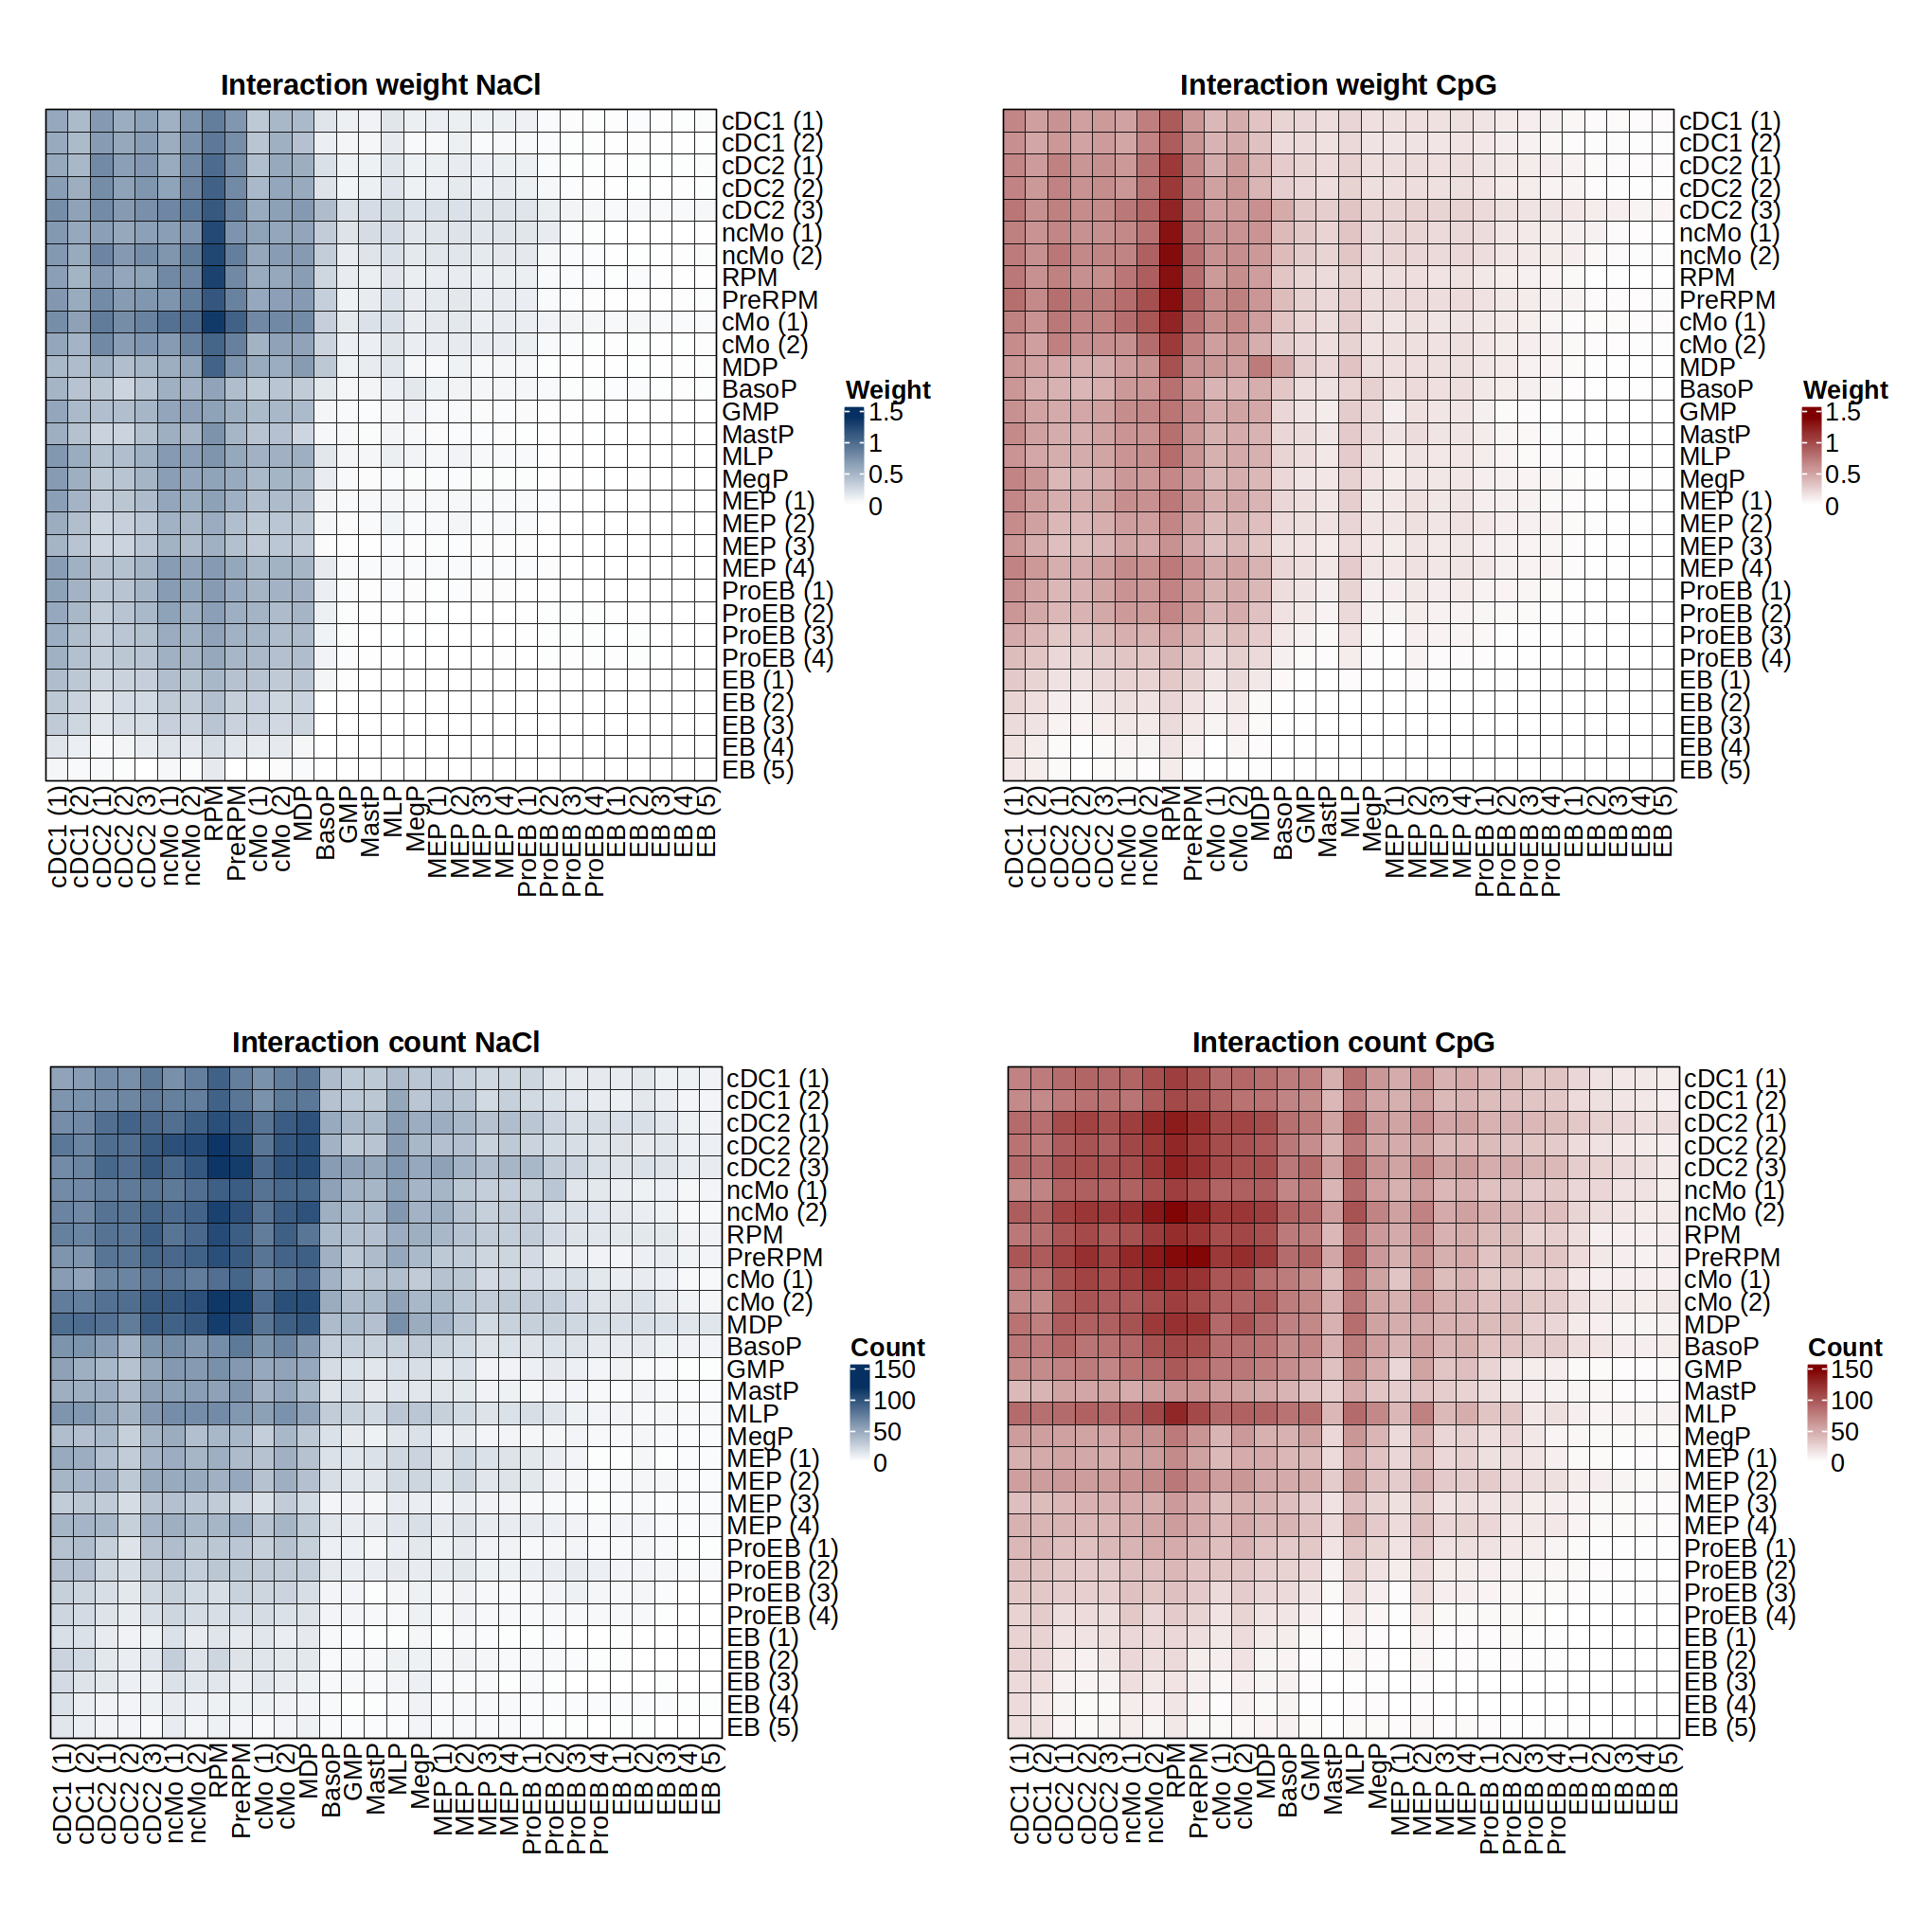

In [40]:
options(repr.plot.width=2+length(cell_type_fine_order)/2, repr.plot.height=2+length(cell_type_fine_order)/2)

hm_1 <- hm_net(cellchat=cellchat_fine_nacl, slot="weight", title="Interaction weight NaCl", color_max=rev(brewer.pal(11,"RdBu"))[1])
hm_2 <- hm_net(cellchat=cellchat_fine_cpg, slot="weight", title="Interaction weight CpG")

hm_3 <- hm_net(cellchat=cellchat_fine_nacl, slot="count", title="Interaction count NaCl", color_max=rev(brewer.pal(11,"RdBu"))[1])
hm_4 <- hm_net(cellchat=cellchat_fine_cpg, slot="count", title="Interaction count CpG")

hm_1 + hm_2 + hm_3 + hm_4

# Plot pathway networks 

In [41]:
plot_list <- list()
for(i in cellchat_main_nacl@netP$pathways) {
    
    pdf(NULL)
    dev.control(displaylist="enable")
    plot_list[[i]] <- netVisual_aggregate(cellchat_main_nacl, signaling=i, layout="chord", color.use=unlist(color$cell_type_main), title.space=1)
    invisible(dev.off())
    
}

In [ ]:
options(repr.plot.width=35, repr.plot.height=5*ceiling(length(plot_list)/7))

cowplot::plot_grid(plotlist=plot_list, ncol=5, nrow=ceiling(length(plot_list)/7))

In [ ]:
plot_list <- list()
for(i in cellchat_main_cpg@netP$pathways) {
    
    pdf(NULL)
    dev.control(displaylist="enable")
    plot_list[[i]] <- netVisual_aggregate(cellchat_main_cpg, signaling=i, layout="chord", color.use=unlist(color$cell_type_main), title.space=1)
    invisible(dev.off())
    
}

In [ ]:
options(repr.plot.width=35, repr.plot.height=5*ceiling(length(plot_list)/7))

cowplot::plot_grid(plotlist=plot_list, ncol=5, nrow=ceiling(length(plot_list)/7))

# Plot gene contribution to pathway

In [ ]:
parilr <- data.frame(interaction_name=c("CCL2_ACKR1", "CCL5_ACKR1", "CCL17_ACKR1"))

In [ ]:
options(repr.plot.width=10, repr.plot.height=5)

sources <- cell_type_main_order[c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)]
targets <- cell_type_main_order[c(11, 12, 13)]

plot_list <- list()

plot_list[[1]] <- netVisual_chord_gene(cellchat_main_nacl, lab.cex=0.5, color.use=unlist(color$cell_type_main), pairLR.use=parilr, thresh=Inf, show.legend=FALSE, sources.use=sources, targets.use=targets, small.gap=3)
plot_list[[2]] <- netVisual_chord_gene(cellchat_main_cpg, lab.cex=0.5, color.use=unlist(color$cell_type_main), pairLR.use=parilr, thresh=Inf, show.legend=FALSE, sources.use=sources, targets.use=targets, small.gap=3)

cowplot::plot_grid(plotlist=plot_list, ncol=2, nrow=1)

In [ ]:
cell_type_fine_order

In [ ]:
options(repr.plot.width=10, repr.plot.height=5)

sources <- cell_type_fine_order[c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)]
targets <- cell_type_fine_order[17:30]

plot_list <- list()

plot_list[[1]] <- netVisual_chord_gene(cellchat_fine_nacl, lab.cex=0.5, color.use=unlist(color$cell_type_fine), pairLR.use=parilr, thresh=0.05, show.legend=FALSE, sources.use=sources, targets.use=targets, small.gap=3)
plot_list[[2]] <- netVisual_chord_gene(cellchat_fine_cpg, lab.cex=0.5, color.use=unlist(color$cell_type_fine), pairLR.use=parilr, thresh=0.05, show.legend=FALSE, sources.use=sources, targets.use=targets, small.gap=3)

cowplot::plot_grid(plotlist=plot_list, ncol=2, nrow=1)

In [ ]:
# png("result/figures/cellchat_ackar1_net_chord_gene_nacl.png", width=10, height=10, units="cm", res=1200)
replayPlot(plot_list[[1]])
dev.off()

# png("result/figures/cellchat_ackar1_net_chord_gene_cpg.png", width=10, height=10, units="cm", res=1200)
replayPlot(plot_list[[2]])
dev.off()

# Compare pathways between treatment groups

In [ ]:
options(repr.plot.width=10, repr.plot.height=15)

gg1 <- rankNet(cellchat_main, mode="comparison", stacked=TRUE, do.stat=TRUE, comparison=c(1, 2)) + scale_fill_manual(values=unlist(color$treatment), breaks=c("CpG", "NaCl")) + theme_global_set() + theme(axis.text.y=element_text(size=8, color="black"), legend.title=element_blank()) 
gg2 <- rankNet(cellchat_fine, mode="comparison", stacked=TRUE, do.stat=TRUE, comparison=c(1, 2)) + scale_fill_manual(values=unlist(color$treatment), breaks=c("CpG", "NaCl")) + theme_global_set() + theme(axis.text.y=element_text(size=8, color="black"), legend.title=element_blank())
gg1 + gg2